#### Weather Station Analysis Module
author: Ali Hanks

This is an example of importing data from a personal Weather Underground 
weather station setup following the instructions here:
    https://radwatch.berkeley.edu/dosenet/weather

In this module, we will be using the station posting data here:
    https://www.wunderground.com/personal-weather-station/dashboard?ID=KCABERKE95

In [164]:
# These first two lines configure the notebook to embed any plots graphed
#   in the body of the notebook
%matplotlib inline
%config InlineBackend.figure_formats=['svg']

# Standard csv and file io python libraries
import csv
import io
import os
import dateutil

# Library for loading data from a webpage (Python 2 and 3 compatible)
from future.standard_library import install_aliases
install_aliases()
from urllib.request import urlopen, Request

# Main python library for mathematical calculations
import numpy as np

# Plotting related python libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Python libraries for manipulating dates and times as objects
from datetime import datetime
from datetime import timedelta
from matplotlib.dates import date2num

Data from Weather Underground for a specific weather station can be requested in CSV format using this format for the url:
https://www.wunderground.com/weatherstation/WXDailyHistory.asp?ID=KCABERKE95&day=2&month=8&year=2017&graphspan=day&format=1

Comma separated values (.CSV) is a filetype that stores tabular data 
in plaintext, and the columns generated by Weather Underground are:
**Time,TemperatureF,DewpointF,PressureIn,WindDirection,WindDirectionDegrees,
WindSpeedMPH,WindSpeedGustMPH,Humidity,HourlyPrecipIn,Conditions,Clouds,
dailyrainin,SolarRadiationWatts/m^2,SoftwareType,DateUTC**

The following function takes the station ID and the date of interest as arguments and processes the data returned by the corresponding url request
and stores and returns the columns of interest as a 2D list of:
**Time,Temperature,Pressure,Windspeed,Humidity,Precipitation,Solar radiation**

For a simple example of reading a csv file from a url web request look at Module 2 - Import Web CSVs

In [165]:
def data_scrap(ID, date):
    #Scrap weather data of given location and given period of time from websites
    #ID is a string contains weather station ID
    #date is a 1 by 3 string array: Month/Date/Year

    data_temp=[] #Stores raw data from the weather station
    str1 = 'https://www.wunderground.com/weatherstation/WXDailyHistory.asp?ID='
    str2 = '&day='
    str3 = '&month='
    str4 = '&year='
    str5 = '&graphspan=day&format=1'
    url = str1+ID+str2+date[1]+str3+date[0]+str4+date[2]+str5
    print(url)
    response = urlopen(url)
    #cr=csv.reader(response)
    cr=csv.reader(io.TextIOWrapper(response))
    for row in cr:
        if len(row)<= 1: continue
        data_temp.append(row)
    
    #Stores data with correct data type (datetime/string/double)
    data = [[0 for i in range(len(data_temp[1][:])-3)] for j in range(len(data_temp))]
    
    for i in range(len(data_temp)):
        if i == 0:
            data[0][:]=data_temp[0][0:len(data_temp[i][:])-2]
        elif i > 0:
            data[i][0]=datetime.strptime(data_temp[i][0], '%Y-%m-%d %H:%M:%S')
            data[i][1:data_temp[0][:].index('WindDirection')]=tuple(float(list_item) for list_item in data_temp[i][1:data_temp[0][:].index('WindDirection')])
            data[i][data_temp[0][:].index('WindDirection')] = data_temp[i][data_temp[0][:].index('WindDirection')]
            data[i][data_temp[0][:].index('WindDirection')+1:data_temp[0][:].index('Conditions')] = tuple(float(list_item) for list_item in data_temp[i][data_temp[0][:].index('WindDirection')+1:data_temp[0][:].index('Conditions')])
            data[i][data_temp[0][:].index('Conditions'):data_temp[0][:].index('Clouds')+1] = data_temp[i][data_temp[0][:].index('Conditions'):data_temp[0][:].index('Clouds')+1]
            data[i][data_temp[0][:].index('Clouds')+1:len(data_temp[0][:])-2] = tuple(float(list_item) for list_item in data_temp[i][data_temp[0][:].index('Clouds')+1:len(data_temp[i][:])-3])
    
    return data

    #Select data for csv file(Date,Temperature, Pressure, Windspeed, Humidity, Hourly Precipitation, and Solar radiation)
    data_csv = [[0 for i in range(7)] for j in range(len(data))]

    for i in range(len(data_temp)):
        data_csv[i][0:2] = data[i][0:2]
        data_csv[i][2] = data[i][3]
        data_csv[i][3] = data[i][6]
        data_csv[i][4:6] = data[i][8:10]
        data_csv[i][6] = data[i][13]
    
    return data_csv

In [191]:
from math import log10, floor

def SetSigfig(x, sig=3):
    return round(x, sig-int(floor(log10(abs(x))))-1)

def importlocalCSV(filepath, filename):
    times_list = []
    degrees_list = []
    pressure_list = []
    humidity_list = []
    row_counter = 0
    file = os.path.join(filepath,filename)
    with open(file) as csvfile:
        reader = csv.reader(csvfile)
        for r in reader:
            if row_counter>0:
                times_list.append(dateutil.parser.parse(r[0]))
                degrees_list.append(float(r[1]))
                pressure_list.append(float(r[2]))
                humidity_list.append(float(r[3]))
                
            row_counter+=1
    times = np.array(times_list)
    degrees = np.array(degrees_list)
    pressure = np.array(pressure_list)
    humidity = np.array(humidity_list)
    temp_ave=[]
    pressure_ave=[]
    humidity_ave=[]
    merge_times = []
    n_merge = 300
    ndata = len(degrees_list)
    nsum_data = int(ndata/n_merge)
    total_time = times[-1] - times[0]
    ntimes = int(total_time.total_seconds()/n_merge)
    starttime = times[0]
    #for i in range(nsum_data):
    for i in range(ntimes):
        stoptime = starttime + timedelta(seconds=300)
        indices = np.where((starttime<=times) & (stoptime>times))
        itemp = degrees[indices]
        temp_mean = np.mean(itemp)
        tempfarenheit = temp_mean * 9/5 +32
        temp_ave.append(SetSigfig(tempfarenheit))

        ipressure = pressure[indices]
        pressure_mean = np.mean(ipressure)
        pressure_ave.append(pressure_mean)

        ihumid = humidity[indices]
        humidity_mean = np.mean(ihumid)
        humidity_ave.append(humidity_mean)

        itimes = times[indices]
        itime = itimes[int(len(itimes)/2)]
        merge_times.append(itime)
        starttime = stoptime
        
        
    return merge_times, temp_ave, pressure_ave, humidity_ave
        

An example main method that uses the data_scrap function defined above to fill lists with all of the data extracted.

**Exercise:** add plotting to this method following Module 3 to generate similar plots for temperature, pressure, and humidity.

In [167]:
def make_plot(date, ydata, plot_title, ytitle, style="r"):
    fig = plt.figure()
    plt.plot(date, ydata, style)
    plt.ylabel(ytitle)
    plt.title(plot_title) 
    fig.autofmt_xdate()
    
def histogram(temperature, plot_title, xtitle):
    fig = plt.figure()
    plt.hist(temperature,bins=35)
    plt.ylabel('Frequency')
    plt.xlabel(xtitle)
    plt.title(plot_title)
    
    
def histogram_WithLabels(data, plot_title, xtitle, xlabels):
    fig, ax = plt.subplots()
    plt.hist(data,bins=35)
    plt.ylabel('Frequency')
    plt.xlabel(xtitle)
    plt.title(plot_title)
    nticks=[i for i in range(1,len(xlabels)+1)]
    ax.set_xticks(nticks)
    ax.set_xticklabels(xlabels, rotation='vertical', fontsize=10)
    
    
def directionMap(directions):
    directionInts = []
    for direction in directions:
        if direction == 'South':
            directionInts.append(1)
        if direction == 'SSW':
            directionInts.append(2)
        if direction == 'SW':
            directionInts.append(3)
        if direction == 'WSW':
            directionInts.append(4)
        if direction == 'West':
            directionInts.append(5)
        if direction == 'WNW':
            directionInts.append(6)
        if direction == 'NW':
            directionInts.append(7)
        if direction == 'NNW':
            directionInts.append(8)
        if direction == 'North':
            directionInts.append(9)
        if direction == 'NNE':
            directionInts.append(10)
        if direction == 'NE':
            directionInts.append(11)
        if direction == 'ENE':
            directionInts.append(12)
        if direction == 'East':
            directionInts.append(13)
        if direction == 'ESE':
            directionInts.append(14)
        if direction == 'SE':
            directionInts.append(15)
        if direction == 'SSE':
            directionInts.append(16)
    DirectionLabels = ['South','SSW','SW','WSW','West','WNW','NW','NNW','North','NNE','NE','ENE','East','ESE','SE','SSE']

    return directionInts,DirectionLabels



In [168]:
def getWeatherStationData(data):
    #Import data from weather station
    date = []
    temperature = []
    pressure = []
    windSpeed = []
    humidity = []
    hourPrecep = []
    solarRadiation = []
    WindDirection = []
    line = 0
    for row in data:
        #skip first row (row that specifies fields)
        if line != 0:
            date.append(row[0])
            temperature.append(row[1])
            pressure.append(row[3])
            windSpeed.append(row[6])
            humidity.append(row[8])
            hourPrecep.append(row[9])
            solarRadiation.append(row[13])
            WindDirection.append(row[4])
        line += 1
    return date, temperature, pressure, windSpeed, humidity, hourPrecep, solarRadiation, WindDirection 

In [192]:
#Get all the data!
# Data from weather sensor
filepath = '/Users/tilman/Downloads'
filename = 'weather_test_results_2017-08-01_18-19-25.csv'
times, degreesSensor, pressureSensor, humiditySensor = importlocalCSV(filepath, filename)

In [170]:
# Data from weather station
start = ['8','3','2017']
location = 'KCABERKE118'
data = data_scrap(location, start)

date, temperature, pressure, windSpeed, humidity, hourPrecep, solarRadiation, WindDirection = getWeatherStationData(data)

https://www.wunderground.com/weatherstation/WXDailyHistory.asp?ID=KCABERKE118&day=3&month=8&year=2017&graphspan=day&format=1


First data point: 2017-08-03 00:01:00, 67.8


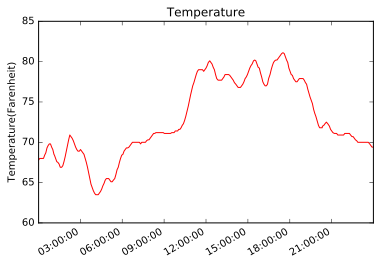

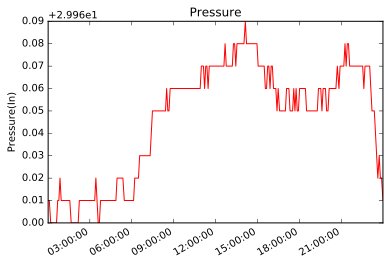

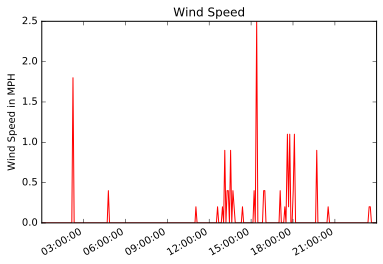

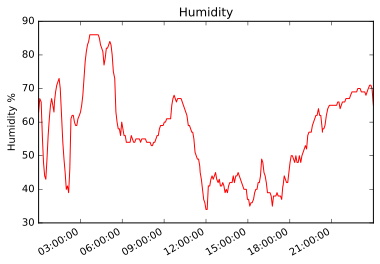

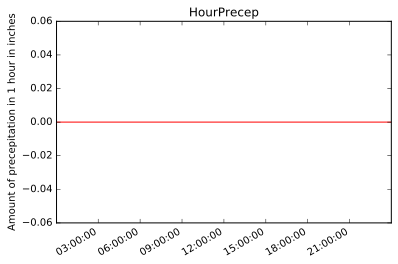

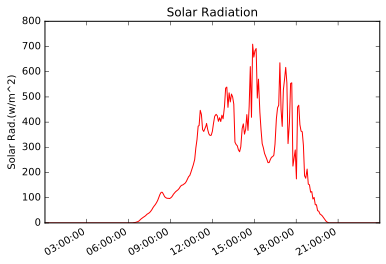

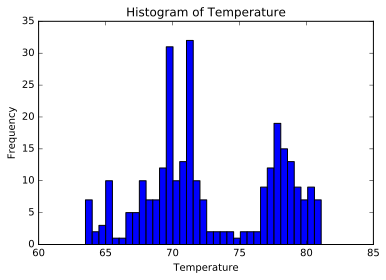

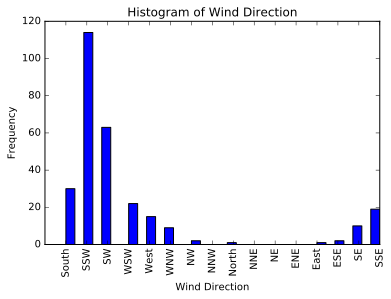

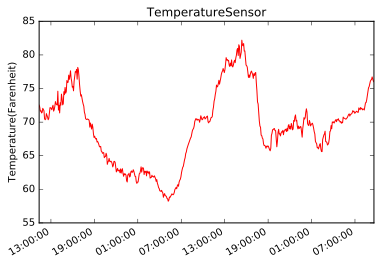

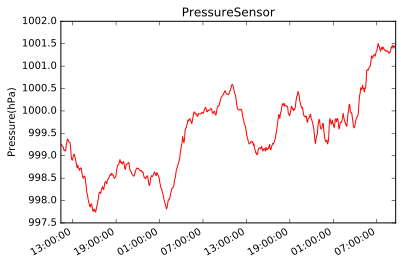

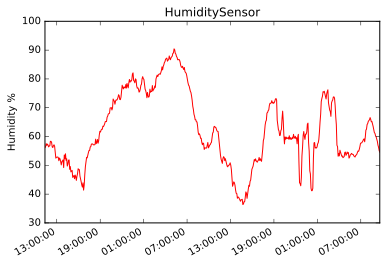

In [171]:
#print(WindDirection)
print('First data point: {}, {}'.format(date[0],temperature[0]))
make_plot(date,temperature,'Temperature','Temperature(Farenheit)')
make_plot(date,pressure,"Pressure",'Pressure(In)')
make_plot(date,windSpeed,"Wind Speed",'Wind Speed in MPH')
make_plot(date,humidity,"Humidity",'Humidity %')
make_plot(date,hourPrecep,"HourPrecep", 'Amount of precepitation in 1 hour in inches')
make_plot(date,solarRadiation,"Solar Radiation", 'Solar Rad.(w/m^2)')
histogram(temperature,"Histogram of Temperature", 'Temperature')
WinddirectionInts,WindDirectionLabels=directionMap(WindDirection)
histogram_WithLabels(WinddirectionInts,"Histogram of Wind Direction", 'Wind Direction', WindDirectionLabels)
make_plot(times, degreesSensor, 'TemperatureSensor','Temperature(Farenheit)') 
make_plot(times, pressureSensor, 'PressureSensor', 'Pressure(hPa)')
make_plot(times, humiditySensor, 'HumiditySensor', 'Humidity %')


In [188]:
mean_temperature = sum(temperature)/len(temperature)
print('Mean of Temp is: %s' %mean_temperature)

mean_degreesSensor = sum(degreesSensor)/len(degreesSensor)
print('Mean of TempSensor is: %s' %mean_degreesSensor)

Mean of Temp is: 72.7982638888889
Mean of TempSensor is: 69.3152466968


In [184]:
median_temperature = np.median(temperature)
print('Median of Temperature is: %s' %median_temperature)

median_degreesSensor = np.median(degreesSensor)
print('Median of TempSensor is: %s' %median_degreesSensor)

Median of Temperature is: 71.2
Median of TempSensor is: 69.8169153001


In [195]:
import statistics
mode_temperature = statistics.mode(temperature)
print('Mode of Temperature is: %s' %mode_temperature)


mode_degreesSensor = statistics.mode(degreesSensor)
print('Mode of TempSensor is: %s' %mode_degreesSensor)


Mode of Temperature is: 70.0
Mode of TempSensor is: 70.4


In [179]:
mean_temperature = sum(temperature)/len(temperature)
temperature_pvariance = sum([(Xi-mean_temperature)**2 for Xi in temperature]) / len(temperature)
print('TempStation variance is: %s' %temperature_pvariance)

mean_degreesSensor = sum(degreesSensor)/len(degreesSensor)
degreesSensor_pvariance = sum([(Xi-mean_degreesSensor)**2 for Xi in degreesSensor]) / len(degreesSensor)
print('TempSensor variance is: %s' %degreesSensor_pvariance)

TempStation variance is: 22.736142819251548
TempSensor variance is: 30.3085890419


In [180]:
temperature_pstdev1 = temperature_pvariance**0.5
print('TempStation Standard Deviation is: %s' %temperature_pstdev1)

degreesSensor_pstdev1 = degreesSensor_pvariance**0.5
print('TempSensor Standard Deviation is: %s' %degreesSensor_pstdev1)

TempStation Standard Deviation is: 4.768243158570203
TempSensor Standard Deviation is: 5.50532370001


In [181]:
def SelectDataRange(start,stop,data,data_times):
    dataarray = np.array(data)
    timesarray = np.array(data_times)

    indices = np.where((timesarray>=start)&(timesarray<=stop))    
    subdata  = dataarray[indices]
    subdatatimes = timesarray[indices]
   
    return subdata, subdatatimes

In [182]:
def doublehistogram(Data1, Data2, plot_title, xtitle):
    fig = plt.figure()
    plt.hist(Data1,bins=35, alpha = 0.6)
    plt.hist(Data2,bins=35, alpha = 0.6)
    plt.ylabel('Frequency')
    plt.xlabel(xtitle)
    plt.title(plot_title)
    legend_labels = ['TempStation', 'TempSensor']
    plt.legend(legend_labels, loc='best')


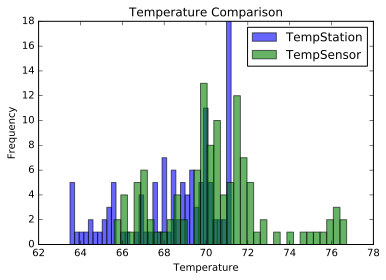

In [183]:
TempSensorarray,Temptimes = SelectDataRange(date[0],date[-1] + timedelta(minutes = 5),degreesSensor,times)
HSensorarray,Humidtimes = SelectDataRange(date[0],date[-1] + timedelta(minutes = 5),humiditySensor,times)
PSensorarray,Pressuretimes = SelectDataRange(date[0],date[-1] + timedelta(minutes = 5),pressureSensor,times)

TempStationarray,Temperatetimes = SelectDataRange(times[0] - timedelta(seconds = 300),times[-1] + timedelta(minutes = 5),temperature,date)
HStationarray,Humiditytimes = SelectDataRange(times[0] - timedelta(seconds = 300),times[-1] + timedelta(minutes = 5),humidity,date)
PStationarray,Presstimes = SelectDataRange(times[0] - timedelta(seconds = 300),times[-1] + timedelta(minutes = 5),pressure,date)


doublehistogram(TempStationarray, TempSensorarray, 'Temperature Comparison', 'Temperature')

In [177]:
print(len(TempStationarray))
print(len(TempSensorarray))
print(Temperatetimes[0])
print(Temptimes[0])

116
116
2017-08-03 00:01:00
2017-08-03 00:02:13.922816


In [ ]:
def correlation_coefficient(xdata,ydata):
    xmean = np.mean(xdata)
    ymean = np.mean(ydata)
    xsigma = np.sqrt(np.var(xdata))
    ysigma = np.sqrt(np.var(ydata))
    xysums = 0
    for i in range(len(xdata)):
        xdiff = xdata[i] - xmean
        ydiff = ydata[i] - ymean
    xysums = xdiff * ydiff +xysums
    stnddevs = xsigma * ysigma
    coeff = xysums/stnddevs/len(xdata)
    return coeff

In [176]:
TempCorr = correlation_coefficient(np.array(TempStationarray), TempSensorarray)

HumidCorr = correlation_coefficient(np.array(HStationarray), HSensorarray)

PressureCorr = correlation_coefficient(np.array(PStationarray), PSensorarray)
print(TempCorr)
print(HumidCorr)
print(PressureCorr)

0.0228372885126
-0.00177470410083
0.0218201109933


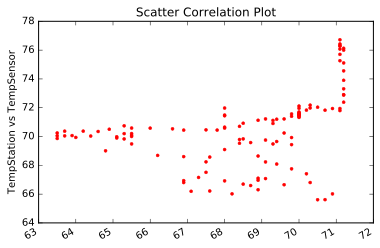

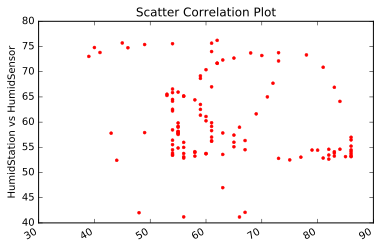

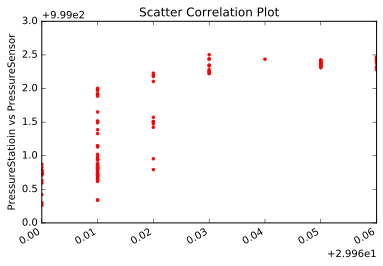

In [175]:
make_plot(TempStationarray, TempSensorarray, 'Scatter Correlation Plot', 'TempStation vs TempSensor', 'r.')
make_plot(HStationarray, HSensorarray, "Scatter Correlation Plot", 'HumidStation vs HumidSensor', 'r.')
make_plot(PStationarray, PSensorarray,'Scatter Correlation Plot', 'PressureStatioin vs PressureSensor', 'r.')